<a href="https://colab.research.google.com/github/lacykaltgr/ait-assessments/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [44]:
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [5]:
def get_books(author: str):
    author_name = author.replace(" ", "+")
    url = f"https://mek.oszk.hu/kereses.mhtml?dc_creator={author_name}&dc_title=&dc_subject=&sort=rk_szerzo%2Crk_uniform&id=&Image3.x=0&Image3.y=0"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    books = []
    for tag in soup.find_all('a'):
      for br in tag.find_all('br'):
          next_s = br.next_sibling
          if not (next_s and isinstance(next_s, str)):
              continue
          text = next_s.strip()
          if text[:5] == "https":
            books.append(f'{text}/{text.split("/")[-1]}.htm')
    return books

def get_text(books):
  text = ""
  for book in books:
    response = requests.get(book)
    soup = BeautifulSoup(response.content, "html.parser")
    print(book)
    for p in soup.find_all('p', {'align': 'justify'}):
        text += " " + p.text.strip()
  return text


mora_books = get_books("Mora Ferenc")
gardonyi_books = get_books("Gardonyi Geza")
if 'https://mek.oszk.hu/04800/04851/04851.htm' in gardonyi_books:
  gardonyi_books.remove('https://mek.oszk.hu/04800/04851/04851.htm')
mora_text = get_text(mora_books)
gardonyi_text = get_text(gardonyi_books)

https://mek.oszk.hu/00600/00685/00685.htm
https://mek.oszk.hu/00900/00961/00961.htm
https://mek.oszk.hu/05900/05900/05900.htm
https://mek.oszk.hu/03300/03305/03305.htm
https://mek.oszk.hu/05100/05156/05156.htm
https://mek.oszk.hu/09500/09530/09530.htm
https://mek.oszk.hu/08000/08016/08016.htm
https://mek.oszk.hu/00900/00963/00963.htm
https://mek.oszk.hu/09500/09578/09578.htm
https://mek.oszk.hu/05300/05322/05322.htm
https://mek.oszk.hu/08100/08182/08182.htm
https://mek.oszk.hu/00900/00964/00964.htm
https://mek.oszk.hu/00900/00965/00965.htm
https://mek.oszk.hu/24400/24460/24460.htm
https://mek.oszk.hu/08600/08624/08624.htm
https://mek.oszk.hu/00900/00962/00962.htm
https://mek.oszk.hu/15500/15573/15573.htm
https://mek.oszk.hu/02500/02568/02568.htm
https://mek.oszk.hu/00900/00966/00966.htm
https://mek.oszk.hu/05300/05355/05355.htm
https://mek.oszk.hu/00900/00967/00967.htm
https://mek.oszk.hu/05200/05283/05283.htm
https://mek.oszk.hu/24500/24579/24579.htm
https://mek.oszk.hu/00900/00968/00

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

<function matplotlib.pyplot.show(close=None, block=None)>

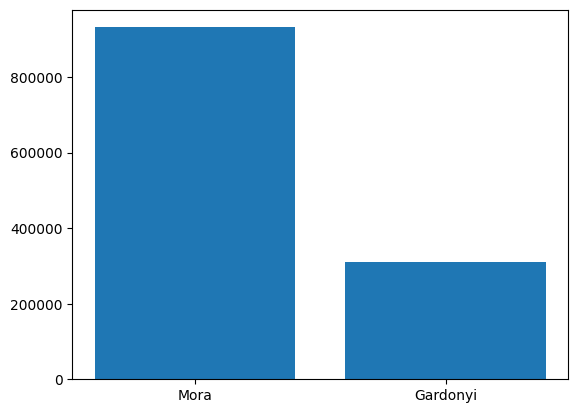

In [6]:
labels = ["Mora", "Gardonyi"]
plt.bar(labels, [len(mora_text), len(gardonyi_text)])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

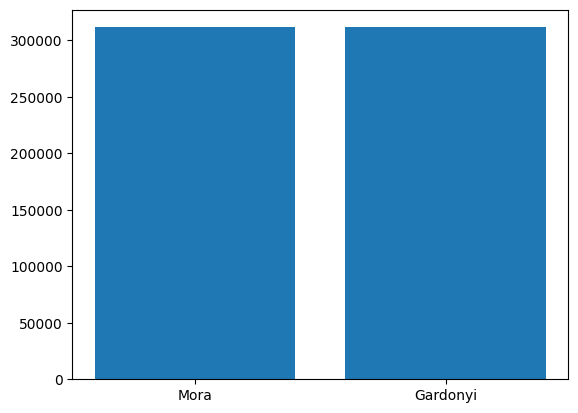

In [7]:
mora_text = mora_text[:len(gardonyi_text)]
plt.bar(labels, [len(mora_text), len(gardonyi_text)])
plt.show

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [8]:
chars = sorted(list(set([*set(mora_text), *set(gardonyi_text)])))

In [11]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [25]:
maxlen  = 60
step    = 30
sequences  = [] 
s_author = [] 

for i in range(0, len(mora_text)-maxlen, step):
    sequences.append(mora_text[i:i+maxlen])
    sequences.append(gardonyi_text[i:i+maxlen])
    s_author.append(0)
    s_author.append(1)

In [29]:
len(s_author)

20768

In [27]:
X = np.zeros((len(sequences), maxlen, len(chars)))
y = np.zeros((len(sequences), 2))

In [30]:
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence): 
        X[i,t,char_indices[char]] = 1
    y[i, s_author[i]] = 1

## Data splitting
Split the data into train, validate and test sets. Make 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [55]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1:]))) # (batch, 128)
model.add(BatchNormalization())
model.add(Dense(len(chars)))
model.add(Dense(2))

model.compile(loss='binary_crossentropy', optimizer='adam')

## Model training
Train the model and apply early stopping.

In [57]:
es = EarlyStopping(monitor='val_loss', patience=10)
model.fit(
    X_train, 
    y_train, 
    batch_size=4096, 
    epochs=1000, 
    validation_data=(X_val, y_val), 
    callbacks=[es])

Epoch 1/1000
4/4 [==============================] - 6s 1s/step - loss: 3.8183 - val_loss: 0.8064
Epoch 2/1000
4/4 [==============================] - 7s 2s/step - loss: 3.7615 - val_loss: 0.7996
Epoch 3/1000
4/4 [==============================] - 5s 1s/step - loss: 3.7041 - val_loss: 0.7941
Epoch 4/1000
4/4 [==============================] - 7s 2s/step - loss: 3.6428 - val_loss: 0.7860
Epoch 5/1000
4/4 [==============================] - 5s 1s/step - loss: 3.5715 - val_loss: 0.7788
Epoch 6/1000
4/4 [==============================] - 7s 2s/step - loss: 3.5085 - val_loss: 0.7735
Epoch 7/1000
4/4 [==============================] - 5s 1s/step - loss: 3.4448 - val_loss: 0.7694
Epoch 8/1000
4/4 [==============================] - 6s 1s/step - loss: 3.3914 - val_loss: 0.7667
Epoch 9/1000
4/4 [==============================] - 7s 1s/step - loss: 3.3134 - val_loss: 0.7641
Epoch 10/1000
4/4 [==============================] - 5s 1s/step - loss: 3.2351 - val_loss: 0.7613
Epoch 11/1000
4/4 [==========

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [58]:
results = model.evaluate(X_test, y_test)

130/130 [==============================] - 2s 12ms/step - loss: 0.7209


In [59]:
results

0.720856785774231

## Confusion matrix
Calculate and display the confusion matrix.